# ***Run Once***


In [2]:
!git clone https://github.com/Ledengary/COPER.git
!pip install hazm
!pip install gdown
!wget https://github.com/sobhe/hazm/releases/download/v0.5/resources-0.5.zip
!unzip -d resources resources-0.5.zip
!gdown 1IuO0X_CXeorxkTZcA2-oDtcrqBCdxxmN

Cloning into 'COPER'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 57 (delta 19), reused 33 (delta 7), pack-reused 0
Unpacking objects: 100% (57/57), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 316 kB 14.7 MB/s 
     |████████████████████████████████| 1.4 MB 63.9 MB/s 
     |████████████████████████████████| 233 kB 61.7 MB/s 
  Created wheel for nltk: filename=nltk-3.3-py3-none-any.whl size=1394488 sha256=803ffe5b48ed28fa63b945bf56707e9e13fc9e3e4bba0bd15db4fa16b351e6e8
  Stored in directory: /root/.cache/pip/wheels/9b/fd/0c/d92302c876e5de87ebd7fc0979d82edb93e2d8d768bf71fac4
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp37-cp37m-linux_x86_64.whl size=154747 sha256=09df858a8091810097107a1cd04d7a9e41e8a6e20d71ece514822e5b1053d135
  Stored in directory: /root/.cache/pip/wheel

#***Import Data***

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt

import hazm
from hazm import word_tokenize

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# ***Data Cleaning***

## Load Data

Bad score rows: Int64Index([733, 1142, 1175, 1909], dtype='int64')


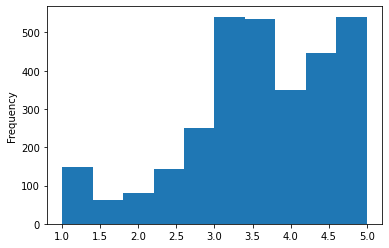

In [4]:
df = pd.read_csv('COPER/Datasets/PerSICK.csv')
df = df.dropna()
print("Bad score rows:", df[df['score'].str.contains("/")].index)
df = df.drop([733, 1142, 1175, 1909])
df['score'] = pd.to_numeric(df['score']).astype("float")
df['score'].plot.hist()

## Find subject of sentences

In [5]:
normalizer = hazm.Normalizer()
lemmatizer = hazm.Lemmatizer()
tagger = hazm.POSTagger(model='resources/postagger.model')
parser = hazm.DependencyParser(tagger=tagger, lemmatizer=lemmatizer)
chunker = hazm.Chunker(model='resources/chunker.model')

In [6]:
def get_full_sbj(graph, node):
    queue = [node['address']]
    subject = node['word']
    while len(queue) > 0:
        node = graph[queue.pop()]
        for dep in node['deps'].values():
            dependency = graph[dep[0]]
            if dependency['address'] < node['address']:
                queue.insert(0, dependency['address'])
                subject = dependency['word'] + " " + subject
            else:
                queue.append(dependency['address'])
                subject = subject + " " + dependency['word']
    return subject

def get_subjects(sentence):
    subjects = []
    normsent = normalizer.normalize(sentence)
    tokenizedsent = hazm.word_tokenize(normsent)
    taggedsent = tagger.tag(tokenizedsent)
    graph = parser.parse(tokenizedsent)
    return graph.nodes
    for node in graph.nodes.values():
        if node['rel'] == 'SBJ':
            subject = get_full_sbj(graph.nodes, node)
            return subject
            subjects.append(subject)
    return subjects

In [7]:
# num = 100
# for i in range(0, 30):
#     testdf = df[i*num:(i+1)*num]
#     testdf['subject1'] = testdf.apply(lambda x: get_subjects(x['sentence1']), axis=1)
#     testdf['subject2'] = testdf.apply(lambda x: get_subjects(x['sentence2']), axis=1)
#     testdf.to_csv(f"{i*num}-{(i+1)*num}.csv")
# csvs = []
# num = 100
# for i in range(0, 30):
#     csvs.append(pd.read_csv(f"{i*num}-{(i+1)*num}.csv"))
# orig_df = pd.concat(csvs)
# orig_df.to_csv("final.csv")

## Load saved csv

In [8]:
df = pd.read_csv("PerSICK_SBJ.csv").drop("Unnamed: 0", axis=1).reset_index(drop=True)
p = df[(df['subject1'] == "[]") | (df['subject2'] == "[]")]
df

,score,sentence1,sentence2,score_discrete,subject1,subject2
0,4.5,گروهی از بچه ها در حیاط بازی می کنند و پیرمردی...,گروهی از پسران در حیاط بازی می کنند و مردی در ...,4.0,گروهی از بچه‌ها,گروهی از پسران
1,3.2,گروهی از کودکان در خانه مشغول بازی هستند و هیچ...,گروهی از بچه ها در حیاط بازی می کنند و پیرمردی...,2.0,گروهی از کودکان,گروهی از بچه‌ها
2,4.7,پسران جوان در فضای باز بازی می کنند و مرد در ه...,بچه ها در بیرون از خانه و در کنار یک مرد با لب...,4.0,پسران جوان,بچه‌ها
3,3.4,بچه ها در بیرون از خانه و در کنار یک مرد با لب...,گروهی از بچه ها در حیاط بازی می کنند و پیرمردی...,3.0,بچه‌ها,گروهی از بچه‌ها
4,3.7,پسران جوان در فضای باز بازی می کنند و مرد در ه...,گروهی از بچه ها در حیاط بازی می کنند و پیرمردی...,3.0,پسران جوان,گروهی از بچه‌ها
...,...,...,...,...,...,...
3092,2.8,سگ سیاه و سفید روی حیاطی سبز نشسته است,سگ سیاه و سفید در حیاطی سبز می دود,2.0,سگ سیاه و سفید,سگ سیاه و سفید
3093,4.8,سگ سیاه و سفید در فضای بیرون می دوید,یک سگ سیاه و سفید در فضای باز در حال دویدن است,4.0,سگ سیاه و سفید,یک سگ سیاه و سفید
3094,3.8,یک زن و مرد در حال پریدن روی حاشیه هستند,یک زن و مرد روی حاشیه ایستاده اند,3.0,یک زن و مرد,یک زن و مرد
3095,3.4,زنی با پیراهن آبی و پاشنه بلند در پیاده رو کنا...,یک زن و مرد روی حاشیه ایستاده اند,3.0,زنی,یک زن و مرد


,score,sentence1,sentence2,score_discrete,subject1,subject2
0,4.5,گروهی از بچه ها در حیاط بازی می کنند و پیرمردی...,گروهی از پسران در حیاط بازی می کنند و مردی در ...,4.0,گروهی از بچه‌ها,گروهی از پسران
1,3.2,گروهی از کودکان در خانه مشغول بازی هستند و هیچ...,گروهی از بچه ها در حیاط بازی می کنند و پیرمردی...,2.0,گروهی از کودکان,گروهی از بچه‌ها
2,4.7,پسران جوان در فضای باز بازی می کنند و مرد در ه...,بچه ها در بیرون از خانه و در کنار یک مرد با لب...,4.0,پسران جوان,بچه‌ها
3,3.4,بچه ها در بیرون از خانه و در کنار یک مرد با لب...,گروهی از بچه ها در حیاط بازی می کنند و پیرمردی...,3.0,بچه‌ها,گروهی از بچه‌ها
4,3.7,پسران جوان در فضای باز بازی می کنند و مرد در ه...,گروهی از بچه ها در حیاط بازی می کنند و پیرمردی...,3.0,پسران جوان,گروهی از بچه‌ها
...,...,...,...,...,...,...
3092,2.8,سگ سیاه و سفید روی حیاطی سبز نشسته است,سگ سیاه و سفید در حیاطی سبز می دود,2.0,سگ سیاه و سفید,سگ سیاه و سفید
3093,4.8,سگ سیاه و سفید در فضای بیرون می دوید,یک سگ سیاه و سفید در فضای باز در حال دویدن است,4.0,سگ سیاه و سفید,یک سگ سیاه و سفید
3094,3.8,یک زن و مرد در حال پریدن روی حاشیه هستند,یک زن و مرد روی حاشیه ایستاده اند,3.0,یک زن و مرد,یک زن و مرد
3095,3.4,زنی با پیراهن آبی و پاشنه بلند در پیاده رو کنا...,یک زن و مرد روی حاشیه ایستاده اند,3.0,زنی,یک زن و مرد


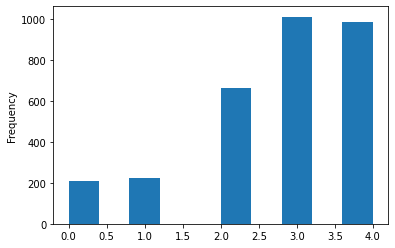

In [9]:
discretizer = KBinsDiscretizer(n_bins=5, strategy='uniform', encode='ordinal')
df['score_discrete'] = discretizer.fit_transform(df['score'].to_numpy().reshape(-1, 1))
df['score_discrete'].plot.hist()
df

## Find group of each row

In [10]:
male = "مرد|پسر|آقا|پدر"
female = "زن|دختر|خانم|مادر|بانو"
child = "کودک|بچه|نوزاد"
animal = "سگ|گربه|آهو|گوزن|یوزپلنگ|طوطی|پرنده|اسب|گوسفند|شامپانزه|میمون|لاکپشت|پاندا|خرس|مار|شیر|میگو|توله|حیوان|کرگدن|ببر|خوک|لمور|همستر|ماهی|تمساح|گاو|سنجاب|زنبور|اردک"
other = "مردم|افراد|فرد|نفر|شخص|اشخاص|جوان"
patterns = [male, female, child, animal]
# def get_group(subject1, subject2):
#     for i, pattern in enumerate(patterns):
#         if re.search(pattern, subject1) and re.search(pattern, subject2):
#             return i
#     return 5

def get_group(subject1, subject2):
    sbjgroup1, sbjgroup2 = 4, 4
    for i, pattern in enumerate(patterns):
        if re.search(pattern, subject1):
            sbjgroup1 = i
            break
    for i, pattern in enumerate(patterns):
        if re.search(pattern, subject2):
            sbjgroup2 = i
            break
    if sbjgroup1 == sbjgroup2:
        return sbjgroup1
    return 5

In [11]:
df['Subject Group']= df.apply(lambda x: get_group(x['subject1'], x['subject2']), axis=1)
df

,score,sentence1,sentence2,score_discrete,subject1,subject2,Subject Group
0,4.5,گروهی از بچه ها در حیاط بازی می کنند و پیرمردی...,گروهی از پسران در حیاط بازی می کنند و مردی در ...,4.0,گروهی از بچه‌ها,گروهی از پسران,5
1,3.2,گروهی از کودکان در خانه مشغول بازی هستند و هیچ...,گروهی از بچه ها در حیاط بازی می کنند و پیرمردی...,2.0,گروهی از کودکان,گروهی از بچه‌ها,2
2,4.7,پسران جوان در فضای باز بازی می کنند و مرد در ه...,بچه ها در بیرون از خانه و در کنار یک مرد با لب...,4.0,پسران جوان,بچه‌ها,5
3,3.4,بچه ها در بیرون از خانه و در کنار یک مرد با لب...,گروهی از بچه ها در حیاط بازی می کنند و پیرمردی...,3.0,بچه‌ها,گروهی از بچه‌ها,2
4,3.7,پسران جوان در فضای باز بازی می کنند و مرد در ه...,گروهی از بچه ها در حیاط بازی می کنند و پیرمردی...,3.0,پسران جوان,گروهی از بچه‌ها,5
...,...,...,...,...,...,...,...
3092,2.8,سگ سیاه و سفید روی حیاطی سبز نشسته است,سگ سیاه و سفید در حیاطی سبز می دود,2.0,سگ سیاه و سفید,سگ سیاه و سفید,3
3093,4.8,سگ سیاه و سفید در فضای بیرون می دوید,یک سگ سیاه و سفید در فضای باز در حال دویدن است,4.0,سگ سیاه و سفید,یک سگ سیاه و سفید,3
3094,3.8,یک زن و مرد در حال پریدن روی حاشیه هستند,یک زن و مرد روی حاشیه ایستاده اند,3.0,یک زن و مرد,یک زن و مرد,0
3095,3.4,زنی با پیراهن آبی و پاشنه بلند در پیاده رو کنا...,یک زن و مرد روی حاشیه ایستاده اند,3.0,زنی,یک زن و مرد,5


In [12]:
print(df['Subject Group'].value_counts())

5    954
0    734
4    480
3    433
1    375
2    121
Name: Subject Group, dtype: int64


## Preprocessing

In [13]:
def preprocess(sentence):
    sentence = normalizer.normalize(sentence)
    sentence = sentence.replace(',', '')
    # sentence = sentence.replace("\u200c", "")
    sentence = re.sub("\s+", " ", sentence).strip()
    return sentence
df['sentence1'] = df.apply(lambda x: preprocess(x['sentence1']), axis=1)
df['sentence2'] = df.apply(lambda x: preprocess(x['sentence2']), axis=1)
df = df.reset_index(drop=True)
df

,score,sentence1,sentence2,score_discrete,subject1,subject2,Subject Group
0,4.5,گروهی از بچه‌ها در حیاط بازی می‌کنند و پیرمردی...,گروهی از پسران در حیاط بازی می‌کنند و مردی در ...,4.0,گروهی از بچه‌ها,گروهی از پسران,5
1,3.2,گروهی از کودکان در خانه مشغول بازی هستند و هیچ...,گروهی از بچه‌ها در حیاط بازی می‌کنند و پیرمردی...,2.0,گروهی از کودکان,گروهی از بچه‌ها,2
2,4.7,پسران جوان در فضای باز بازی می‌کنند و مرد در ه...,بچه‌ها در بیرون از خانه و در کنار یک مرد با لب...,4.0,پسران جوان,بچه‌ها,5
3,3.4,بچه‌ها در بیرون از خانه و در کنار یک مرد با لب...,گروهی از بچه‌ها در حیاط بازی می‌کنند و پیرمردی...,3.0,بچه‌ها,گروهی از بچه‌ها,2
4,3.7,پسران جوان در فضای باز بازی می‌کنند و مرد در ه...,گروهی از بچه‌ها در حیاط بازی می‌کنند و پیرمردی...,3.0,پسران جوان,گروهی از بچه‌ها,5
...,...,...,...,...,...,...,...
3092,2.8,سگ سیاه و سفید روی حیاطی سبز نشسته است,سگ سیاه و سفید در حیاطی سبز می‌دود,2.0,سگ سیاه و سفید,سگ سیاه و سفید,3
3093,4.8,سگ سیاه و سفید در فضای بیرون می‌دوید,یک سگ سیاه و سفید در فضای باز در حال دویدن است,4.0,سگ سیاه و سفید,یک سگ سیاه و سفید,3
3094,3.8,یک زن و مرد در حال پریدن روی حاشیه هستند,یک زن و مرد روی حاشیه ایستاده‌اند,3.0,یک زن و مرد,یک زن و مرد,0
3095,3.4,زنی با پیراهن آبی و پاشنه بلند در پیاده رو کنا...,یک زن و مرد روی حاشیه ایستاده‌اند,3.0,زنی,یک زن و مرد,5


#***Tokenizer***

In [14]:
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

class TokenizerFa:
    def __init__(self, df, max_len, max_words):
        self.df = df
        self.max_len = max_len
        self.max_words = max_words
        
    def prepare_tokens(self):
        self.tokens = Tokenizer(num_words=self.max_words, oov_token=1, lower=False)
        self.tokens.fit_on_texts(list(self.df.loc[:, 'sentence1']) + list(self.df.loc[:, 'sentence2']))
        
    def tokenize(self, x):
        sequences = self.tokens.texts_to_sequences(x)
        return torch.tensor(sequence.pad_sequences(sequences, maxlen=self.max_len, padding='post', truncating='post')).reshape(self.max_len)

#***Dataset and Dataloader***

In [15]:
class dataset(Dataset):
    def __init__(self, df, maxlen, vocabsize):
        self.df = df
        self.maxlen = maxlen
        self.tokenizer = TokenizerFa(df, maxlen, vocabsize)
        self.tokenizer.prepare_tokens()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, item):
        tokens1 = self.tokenizer.tokenize([str(self.df['sentence1'].iloc[item])])
        tokens2 = self.tokenizer.tokenize([str(self.df['sentence2'].iloc[item])])
        
        sbjgroup = np.eye(6)[int(self.df['Subject Group'].iloc[item])]
        simscore = np.eye(5)[int(self.df['score_discrete'].iloc[item])]
        o = np.concatenate((sbjgroup, simscore))

        return {
            'sentence1': self.df['sentence1'].iloc[item],
            'sentence2': self.df['sentence2'].iloc[item],
            'input_ids1': tokens1.flatten(),
            'input_ids2': tokens2.flatten(),
            'subjectgroup': torch.tensor(self.df['Subject Group'].iloc[item], dtype=torch.long),
            'score': torch.tensor(self.df['score_discrete'].iloc[item], dtype=torch.float),
            'target': torch.tensor(o, dtype=torch.float),
        }

In [16]:
BATCH_SIZE = 32
MAXLEN = max(df.apply(lambda x: max(len(word_tokenize(x['sentence1'])), len(word_tokenize(x['sentence2']))), axis = 1))
VOCABSIZE = 2500

df_train, df_test = train_test_split(df, test_size=0.2, shuffle=True)

weights = 1 / df_train.groupby(["score_discrete"])['score'].count()
df_train['prob'] = df_train.apply(lambda x: weights[x['score_discrete']], axis=1)

probs = torch.tensor(list(df_train['prob'])).double()
sampler = torch.utils.data.sampler.WeightedRandomSampler(probs, len(probs))
trainset = dataset(df_train, maxlen=MAXLEN, vocabsize=VOCABSIZE)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, sampler=sampler)

testset = dataset(df_test, maxlen=MAXLEN, vocabsize=VOCABSIZE)
testloader = DataLoader(testset, batch_size=BATCH_SIZE)

In [17]:
trainset[1]

{'input_ids1': tensor([ 99,   2,   5,  19,   7, 299,   3,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        dtype=torch.int32),
 'input_ids2': tensor([ 768,   10,  162,   36, 1801,  204,   28,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0], dtype=torch.int32),
 'score': tensor(0.),
 'sentence1': 'گربه در حال بازی با دستگاه است',
 'sentence2': 'لجن به سمت پسر بازیگر پرتاب می\u200cشود',
 'subjectgroup': tensor(5),
 'target': tensor([0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.])}

## Balanced dataset

In [18]:
a = [0 for i in range(5)]
for data in trainloader:
    for i in data['score']:
        a[int(i.item())] += 1
a

[493, 503, 517, 478, 486]

#***Utility functions***

In [19]:
def train(model, trainloader, criterion, optimizer, n):
    corrects = 0 
    losses = []
    model.train()
    for data in trainloader:
        X1 = data['input_ids1'].to(device)
        X2 = data['input_ids2'].to(device)
        y = data['target'].to(device)
        sbjgroup = data['subjectgroup'].to(device)
        simscore = data['score'].to(device)
        
        output = model(X1, X2)
        _, predict1 = torch.max(output[:, :6], dim = 1)
        _, predict2 = torch.max(output[:, 6:], dim = 1)

        corrects += torch.sum(predict1 == sbjgroup)
        corrects += torch.sum(predict2 == simscore)

        loss = criterion(output, y)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    return (corrects.item() / (2*n)), np.mean(losses)

In [20]:
def validation(model, testloader, criterion, n):
    losses = []
    corrects = 0
    model.eval()
    with torch.no_grad():
        for data in testloader:
            X1 = data['input_ids1'].to(device)
            X2 = data['input_ids2'].to(device)
            y = data['target'].to(device)
            sbjgroup = data['subjectgroup'].to(device)
            simscore = data['score'].to(device)
        
            output = model(X1, X2)
            _, predict1 = torch.max(output[:, :6], dim = 1)
            _, predict2 = torch.max(output[:, 6:], dim = 1)

            corrects += torch.sum(predict1 == sbjgroup)
            corrects += torch.sum(predict2 == simscore)

            loss = criterion(output, y)
            losses.append(loss.item())
    return (corrects / (2*n)), np.mean(losses)

In [21]:
def fit(model, criterion, optimizer, EPOCHS):
    losses_train, losses_valid, acc_train, acc_valid, predicts = ([] for i in range(5))
    best_acc = 0

    for e in range(EPOCHS):
        train_c, train_l = train(model, trainloader, criterion, optimizer, len(trainset))
        print(f"Epoch {e + 1} --- train accuracy {train_c * 100:.3f}    train losses {train_l:.3f}", end='')
        losses_train.append(train_l)  
        acc_train.append(train_c)  

        val_c, val_l = validation(model, testloader, criterion, len(testset))
        print(f" --- valid accuracy {val_c * 100:.3f}   valid losses {val_l:.3f}")
        losses_valid.append(val_l)
        acc_valid.append(val_c)
    return losses_train, losses_valid, acc_train, acc_valid

In [22]:
def show_metrics(model, dataloader, task, filename=None):
    y_pred = []
    y_true = []
    with torch.no_grad():
        for data in dataloader:
            X1 = data['input_ids1']#.to(device)
            X2 = data['input_ids2']#.to(device)
            
            output = model(X1.to(device), X2.to(device))
            if task == 0:
                y = data['subjectgroup']
                _, pred = torch.max(output[:, :6], dim = 1)
            else:
                y = data['score']
                _, pred = torch.max(output[:, 6:], dim = 1)
            y_pred.append(pred)
            y_true.append(y)
    y_pred = torch.cat(y_pred).cpu()
    y_true = torch.cat(y_true)
    creport = classification_report(y_true, y_pred)
    if task == 0:
        print("----- Suubject group ------")
    else:        
        print("----- Similarity ------")
    print(creport)
    disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred))
    disp.plot()
    if filename:
        plt.savefig(filename)

In [23]:
def plotplz(filename=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
    # ax1.title("Training and Validation Accuracy")
    ax1.plot(acc_valid,label="val")
    ax1.plot(acc_train,label="train")
    ax1.set_xlabel("iterations")
    ax1.set_ylabel("accuracy")
    ax1.legend()

    ax2.plot(losses_valid,label="val")
    ax2.plot(losses_train,label="train")
    ax2.set_xlabel("iterations")
    ax2.set_ylabel("loss")
    ax2.legend()
    if filename:
        fig.savefig(filename)

#***Model***

## LSTM

In [24]:
class LSTM_fixed_len(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim, num_layers = 2, bidirectional = True, dropout = dropout, batch_first=True)
        self.lstm2 = nn.LSTM(embedding_dim, hidden_dim, num_layers = 2, bidirectional = True, dropout = dropout, batch_first=True)
        self.fc4 = nn.Linear(256, 11)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x1, x2):
        x1 = self.embeddings(x1)
        x1 = self.dropout(x1)
        lstm_out1, (ht1, ct) = self.lstm1(x1)
#         output1 = ht1[-1]
#         output1 = lstm_out1[:, -1, :]
        output1 = torch.cat((ht1[-2,:,:], ht1[-1,:,:]), dim = 1)
    
        x2 = self.embeddings(x2)
        x2 = self.dropout(x2)
        lstm_out2, (ht2, ct) = self.lstm2(x2)
#         output2 = ht2[-1]
#         output2 = lstm_out2[:, -1, :]
        output2 = torch.cat((ht2[-2,:,:], ht2[-1,:,:]), dim = 1)
       
        output = torch.cat([output1, output2], dim = 1)
        output = self.fc4(output)
        return output

In [25]:
model = LSTM_fixed_len(vocab_size=VOCABSIZE, embedding_dim=64, hidden_dim=64, dropout=0.5).to(device)
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
losses_train, losses_valid, acc_train, acc_valid = fit(model, criterion, optimizer, 350)

Epoch 1 --- train accuracy 29.471    train losses 0.473 --- valid accuracy 27.419   valid losses 0.449
Epoch 2 --- train accuracy 40.270    train losses 0.399 --- valid accuracy 28.145   valid losses 0.463
Epoch 3 --- train accuracy 49.717    train losses 0.363 --- valid accuracy 25.887   valid losses 0.515
Epoch 4 --- train accuracy 53.068    train losses 0.342 --- valid accuracy 30.403   valid losses 0.507
Epoch 5 --- train accuracy 54.865    train losses 0.335 --- valid accuracy 31.935   valid losses 0.508
Epoch 6 --- train accuracy 58.740    train losses 0.318 --- valid accuracy 28.952   valid losses 0.547
Epoch 7 --- train accuracy 60.416    train losses 0.307 --- valid accuracy 29.435   valid losses 0.547
Epoch 8 --- train accuracy 61.990    train losses 0.295 --- valid accuracy 33.226   valid losses 0.559
Epoch 9 --- train accuracy 62.455    train losses 0.294 --- valid accuracy 32.581   valid losses 0.565
Epoch 10 --- train accuracy 63.242    train losses 0.287 --- valid accura

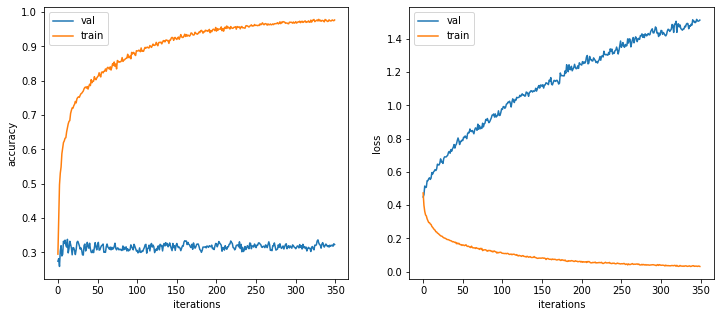

In [26]:
for i in range(len(acc_valid)):
    acc_valid[i] = acc_valid[i].cpu()
plotplz()

----- Similarity ------
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       493
         1.0       0.98      1.00      0.99       492
         2.0       0.99      0.99      0.99       470
         3.0       0.99      0.97      0.98       500
         4.0       0.98      0.98      0.98       522

    accuracy                           0.99      2477
   macro avg       0.99      0.99      0.99      2477
weighted avg       0.99      0.99      0.99      2477

----- Suubject group ------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       559
           1       1.00      1.00      1.00       312
           2       1.00      1.00      1.00        81
           3       1.00      1.00      1.00       278
           4       1.00      1.00      1.00       342
           5       1.00      1.00      1.00       905

    accuracy                           1.00      2477
   macro avg       1.00  

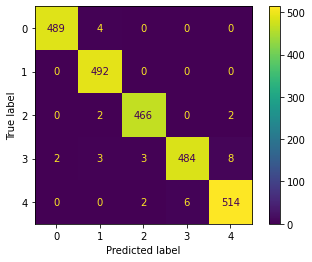

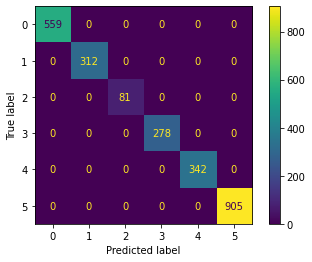

In [27]:
show_metrics(model, trainloader, task = 1)
show_metrics(model, trainloader, task = 0)

----- Suubject group ------
              precision    recall  f1-score   support

           0       0.64      0.44      0.52       155
           1       0.20      0.18      0.19        67
           2       0.12      0.09      0.10        23
           3       0.30      0.23      0.26        86
           4       0.21      0.29      0.24       103
           5       0.36      0.44      0.39       186

    accuracy                           0.34       620
   macro avg       0.30      0.28      0.28       620
weighted avg       0.37      0.34      0.35       620

----- Similarity ------
              precision    recall  f1-score   support

         0.0       0.15      0.12      0.13        41
         1.0       0.08      0.04      0.06        46
         2.0       0.24      0.20      0.22       153
         3.0       0.29      0.32      0.30       184
         4.0       0.39      0.46      0.42       196

    accuracy                           0.30       620
   macro avg       0.23  

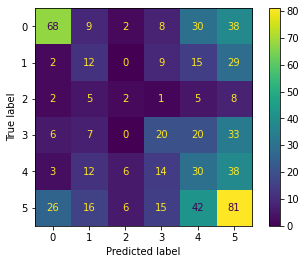

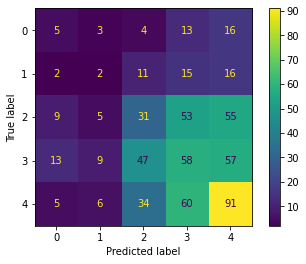

In [28]:
show_metrics(model, testloader, task = 0)
show_metrics(model, testloader, task = 1)

## GRU

In [29]:
class LSTM_fixed_len(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.gru1 = nn.GRU(embedding_dim, hidden_dim, num_layers = 2, bidirectional = True, dropout = dropout, batch_first=True)
        self.gru2 = nn.GRU(embedding_dim, hidden_dim, num_layers = 2, bidirectional = True, dropout = dropout, batch_first=True)
        self.linear = nn.Linear(hidden_dim * 4, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 11)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x1, x2):
        x1 = self.embeddings(x1)
        x1 = self.dropout(x1)
        gru_out1, ht1 = self.gru1(x1)
#         output1 = ht1[-1]
        # output1 = lstm_out1[:, -1, :]
        output1 = torch.cat((ht1[-2,:,:], ht1[-1,:,:]), dim = 1)
    
        x2 = self.embeddings(x2)
        x2 = self.dropout(x2)
        gru_out2, ht2 = self.gru2(x2)
#         output2 = ht2[-1]
        # output2 = lstm_out2[:, -1, :]
        output2 = torch.cat((ht2[-2,:,:], ht2[-1,:,:]), dim = 1)
       
        output = torch.cat([output1, output2], dim = 1)
        output = F.relu(self.linear(output))
        output = F.relu(self.fc2(output))
        output = self.fc3(output)
        return output

In [30]:
model = LSTM_fixed_len(vocab_size=VOCABSIZE, embedding_dim=64, hidden_dim=64, dropout=0.5).to(device)
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
losses_train, losses_valid, acc_train, acc_valid = fit(model, criterion, optimizer, 350)

Epoch 1 --- train accuracy 28.623    train losses 0.475 --- valid accuracy 29.435   valid losses 0.453
Epoch 2 --- train accuracy 39.261    train losses 0.398 --- valid accuracy 31.210   valid losses 0.477
Epoch 3 --- train accuracy 46.286    train losses 0.357 --- valid accuracy 29.435   valid losses 0.504
Epoch 4 --- train accuracy 52.442    train losses 0.331 --- valid accuracy 30.968   valid losses 0.533
Epoch 5 --- train accuracy 54.219    train losses 0.320 --- valid accuracy 29.194   valid losses 0.546
Epoch 6 --- train accuracy 55.511    train losses 0.303 --- valid accuracy 28.710   valid losses 0.567
Epoch 7 --- train accuracy 58.054    train losses 0.293 --- valid accuracy 31.694   valid losses 0.581
Epoch 8 --- train accuracy 58.922    train losses 0.288 --- valid accuracy 30.887   valid losses 0.567
Epoch 9 --- train accuracy 60.153    train losses 0.277 --- valid accuracy 31.129   valid losses 0.586
Epoch 10 --- train accuracy 62.878    train losses 0.264 --- valid accura

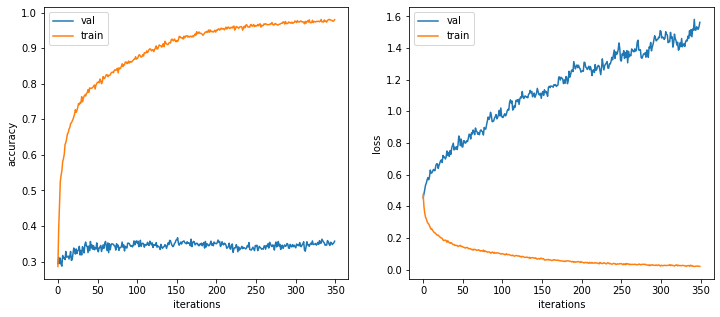

In [31]:
for i in range(len(acc_valid)):
    acc_valid[i] = acc_valid[i].cpu()
plotplz()

----- Suubject group ------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       582
           1       1.00      1.00      1.00       317
           2       1.00      1.00      1.00        74
           3       1.00      1.00      1.00       262
           4       1.00      1.00      1.00       352
           5       1.00      1.00      1.00       890

    accuracy                           1.00      2477
   macro avg       1.00      1.00      1.00      2477
weighted avg       1.00      1.00      1.00      2477

----- Similarity ------
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       529
         1.0       0.99      1.00      1.00       471
         2.0       0.99      0.99      0.99       498
         3.0       0.99      0.99      0.99       503
         4.0       1.00      1.00      1.00       476

    accuracy                           1.00      2477
   macro avg       1.00  

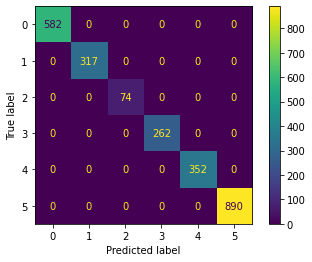

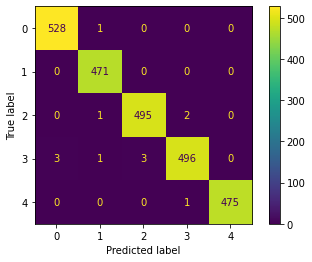

In [32]:
show_metrics(model, trainloader, task = 0)
show_metrics(model, trainloader, task = 1)

----- Suubject group ------
              precision    recall  f1-score   support

           0       0.78      0.39      0.52       155
           1       0.14      0.15      0.15        67
           2       0.08      0.04      0.06        23
           3       0.17      0.13      0.14        86
           4       0.30      0.61      0.41       103
           5       0.51      0.52      0.51       186

    accuracy                           0.39       620
   macro avg       0.33      0.31      0.30       620
weighted avg       0.44      0.39      0.39       620

----- Similarity ------
              precision    recall  f1-score   support

         0.0       0.21      0.20      0.20        41
         1.0       0.11      0.07      0.08        46
         2.0       0.31      0.28      0.30       153
         3.0       0.32      0.35      0.34       184
         4.0       0.38      0.42      0.40       196

    accuracy                           0.32       620
   macro avg       0.27  

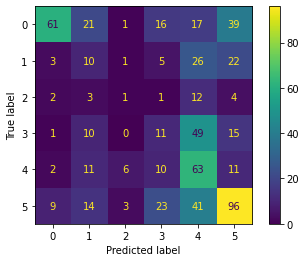

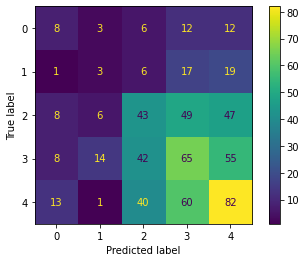

In [33]:
show_metrics(model, testloader, task = 0)
show_metrics(model, testloader, task = 1)

## RNN

In [34]:
class LSTM_fixed_len(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.rnn1 = nn.RNN(embedding_dim, hidden_dim, num_layers = 2, bidirectional = True, dropout = dropout, batch_first=True)
        self.rnn2 = nn.RNN(embedding_dim, hidden_dim, num_layers = 2, bidirectional = True, dropout = dropout, batch_first=True)
        self.linear = nn.Linear(hidden_dim * 4, 11)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x1, x2):
        x1 = self.embeddings(x1)
        x1 = self.dropout(x1)
        rnn_out1, ht1 = self.rnn1(x1)
#         output1 = ht1[-1]
        # output1 = lstm_out1[:, -1, :]
        output1 = torch.cat((ht1[-2,:,:], ht1[-1,:,:]), dim = 1)
    
        x2 = self.embeddings(x2)
        x2 = self.dropout(x2)
        rnn_out2, ht2 = self.rnn2(x2)
#         output2 = ht2[-1]
        # output2 = lstm_out2[:, -1, :]
        output2 = torch.cat((ht2[-2,:,:], ht2[-1,:,:]), dim = 1)
       
        output = torch.cat([output1, output2], dim = 1)
        # output = self.relu(self.linear(output))
        output = self.linear(output)
        return output

In [35]:
model = LSTM_fixed_len(vocab_size=VOCABSIZE, embedding_dim=64, hidden_dim=64, dropout=0.5).to(device)
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
losses_train, losses_valid, acc_train, acc_valid = fit(model, criterion, optimizer, 100)

Epoch 1 --- train accuracy 33.327    train losses 0.450 --- valid accuracy 32.339   valid losses 0.436
Epoch 2 --- train accuracy 43.137    train losses 0.393 --- valid accuracy 34.113   valid losses 0.429
Epoch 3 --- train accuracy 48.264    train losses 0.371 --- valid accuracy 30.887   valid losses 0.460
Epoch 4 --- train accuracy 50.182    train losses 0.354 --- valid accuracy 33.065   valid losses 0.460
Epoch 5 --- train accuracy 51.938    train losses 0.347 --- valid accuracy 33.629   valid losses 0.471
Epoch 6 --- train accuracy 53.492    train losses 0.340 --- valid accuracy 32.742   valid losses 0.486
Epoch 7 --- train accuracy 56.581    train losses 0.331 --- valid accuracy 32.500   valid losses 0.485
Epoch 8 --- train accuracy 56.136    train losses 0.325 --- valid accuracy 34.839   valid losses 0.474
Epoch 9 --- train accuracy 57.812    train losses 0.323 --- valid accuracy 31.532   valid losses 0.505
Epoch 10 --- train accuracy 57.671    train losses 0.319 --- valid accura

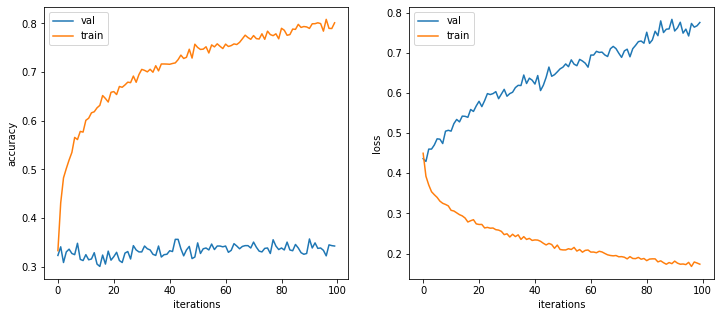

In [36]:
for i in range(len(acc_valid)):
    acc_valid[i] = acc_valid[i].cpu()
plotplz()

----- Suubject group ------
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       572
           1       0.97      1.00      0.99       311
           2       0.96      1.00      0.98        81
           3       0.98      0.99      0.98       281
           4       0.96      1.00      0.98       298
           5       1.00      0.95      0.97       934

    accuracy                           0.98      2477
   macro avg       0.97      0.99      0.98      2477
weighted avg       0.98      0.98      0.98      2477

----- Similarity ------
              precision    recall  f1-score   support

         0.0       0.84      1.00      0.91       491
         1.0       0.90      0.98      0.94       486
         2.0       0.61      0.53      0.57       479
         3.0       0.66      0.32      0.44       519
         4.0       0.53      0.72      0.61       502

    accuracy                           0.71      2477
   macro avg       0.71  

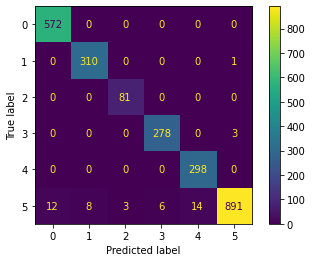

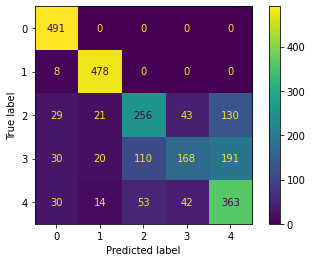

In [37]:
show_metrics(model, trainloader, task = 0)
show_metrics(model, trainloader, task = 1)

----- Suubject group ------
              precision    recall  f1-score   support

           0       0.72      0.50      0.59       155
           1       0.16      0.24      0.19        67
           2       0.10      0.04      0.06        23
           3       0.36      0.12      0.18        86
           4       0.29      0.56      0.38       103
           5       0.42      0.39      0.40       186

    accuracy                           0.38       620
   macro avg       0.34      0.31      0.30       620
weighted avg       0.42      0.38      0.38       620

----- Similarity ------
              precision    recall  f1-score   support

         0.0       0.12      0.24      0.16        41
         1.0       0.07      0.07      0.07        46
         2.0       0.24      0.25      0.24       153
         3.0       0.44      0.28      0.34       184
         4.0       0.40      0.45      0.42       196

    accuracy                           0.31       620
   macro avg       0.25  

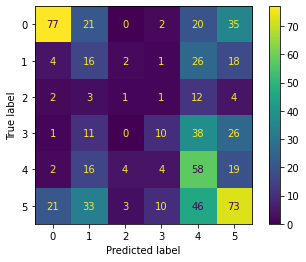

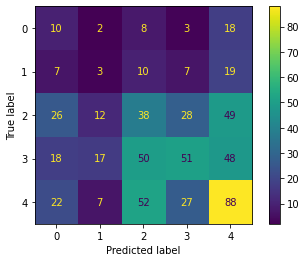

In [38]:
show_metrics(model, testloader, task = 0)
show_metrics(model, testloader, task = 1)

## Bert

In [39]:
!pip install transformers

from transformers import AutoTokenizer, AutoConfig, AutoModel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 14.8 MB/s 
     |████████████████████████████████| 101 kB 13.8 MB/s 
     |████████████████████████████████| 6.6 MB 55.6 MB/s 
     |████████████████████████████████| 596 kB 53.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [40]:
parsbert_model = 'HooshvareLab/bert-fa-zwnj-base'

In [41]:
class dataset(Dataset):
    def __init__(self, df, maxlen, vocabsize):
        self.df = df
        self.maxlen = maxlen
        self.tokenizer = AutoTokenizer.from_pretrained(parsbert_model)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, item):
        tokens1 = self.tokenizer([str(self.df['sentence1'].iloc[item])],
                                 max_length=self.maxlen,
                                 padding='max_length',
                                 truncation=True,
                                 return_tensors='pt',
                                 return_token_type_ids=False
                                )
        tokens2 = self.tokenizer([str(self.df['sentence2'].iloc[item])],
                                 max_length=self.maxlen,
                                 padding='max_length',
                                 truncation=True,
                                 return_tensors='pt',
                                 return_token_type_ids=False
                                )
        
        sbjgroup = np.eye(6)[int(self.df['Subject Group'].iloc[item])]
        simscore = np.eye(5)[int(self.df['score_discrete'].iloc[item])]
        o = np.concatenate((sbjgroup, simscore))

        return {
            'sentence1': self.df['sentence1'].iloc[item],
            'sentence2': self.df['sentence2'].iloc[item],
            'input_ids1': tokens1['input_ids'].flatten(),
            'input_ids2': tokens2['input_ids'].flatten(),
            'attention_mask1': tokens1['attention_mask'].flatten(),
            'attention_mask2': tokens2['attention_mask'].flatten(),
            'subjectgroup': torch.tensor(self.df['Subject Group'].iloc[item], dtype=torch.long),
            'score': torch.tensor(self.df['score_discrete'].iloc[item], dtype=torch.float),
            'target': torch.tensor(o, dtype=torch.float),
        }

In [42]:
BATCH_SIZE = 32
MAXLEN = max(df.apply(lambda x: max(len(word_tokenize(x['sentence1'])), len(word_tokenize(x['sentence2']))), axis = 1))
VOCABSIZE = 2500

df_train, df_test = train_test_split(df, test_size=0.2, shuffle=True)

weights = 1 / df_train.groupby(["score_discrete"])['score'].count()
df_train['prob'] = df_train.apply(lambda x: weights[x['score_discrete']], axis=1)

probs = torch.tensor(list(df_train['prob'])).double()
sampler = torch.utils.data.sampler.WeightedRandomSampler(probs, len(probs))
trainset = dataset(df_train, maxlen=MAXLEN, vocabsize=VOCABSIZE)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, sampler=sampler)

testset = dataset(df_test, maxlen=MAXLEN, vocabsize=VOCABSIZE)
testloader = DataLoader(testset, batch_size=BATCH_SIZE)

Downloading:   0%|          | 0.00/292 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/565 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/134 [00:00<?, ?B/s]

In [43]:
class LSTM_fixed_len(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout) :
        super().__init__()
        cfg = AutoConfig.from_pretrained(
            parsbert_model,
            hidden_dropout_prob= 0.3,
            classifier_dropout= 0.3
        )
        
        self.bert = AutoModel.from_config(cfg)
        self.gru1 = nn.GRU(768, hidden_dim, num_layers = 2, bidirectional = True, dropout = dropout, batch_first=True)
        self.gru2 = nn.GRU(768, hidden_dim, num_layers = 2, bidirectional = True, dropout = dropout, batch_first=True)
        self.linear = nn.Linear(hidden_dim * 4, 11)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 11)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x1, att1, x2, att2):
        with torch.no_grad():
            x1 = self.bert(
                input_ids=x1,
                attention_mask=att1,
                return_dict=False
            )[0]
        x1 = self.dropout(x1)
        gru_out1, ht1 = self.gru1(x1)
#         output1 = ht1[-1]
        # output1 = lstm_out1[:, -1, :]
        output1 = torch.cat((ht1[-2,:,:], ht1[-1,:,:]), dim = 1)
    
        with torch.no_grad():
            x2 = self.bert(
                input_ids=x2,
                attention_mask=att2,
                return_dict=False
            )[0]
        x2 = self.dropout(x2)
        gru_out2, ht2 = self.gru2(x2)
#         output2 = ht2[-1]
        # output2 = lstm_out2[:, -1, :]
        output2 = torch.cat((ht2[-2,:,:], ht2[-1,:,:]), dim = 1)
       
        output = torch.cat([output1, output2], dim = 1)
        output = self.linear(output)
        return output

In [44]:
def train(model, trainloader, criterion, optimizer, n):
    corrects = 0 
    losses = []
    model.train()
    for data in trainloader:
        X1 = data['input_ids1'].to(device)
        X2 = data['input_ids2'].to(device)
        att1 = data['attention_mask1'].to(device)
        att2 = data['attention_mask2'].to(device)
        y = data['target'].to(device)
        sbjgroup = data['subjectgroup'].to(device)
        simscore = data['score'].to(device)
        
        output = model(X1, att1, X2, att2)
        _, predict1 = torch.max(output[:, :6], dim = 1)
        _, predict2 = torch.max(output[:, 6:], dim = 1)

        corrects += torch.sum(predict1 == sbjgroup)
        corrects += torch.sum(predict2 == simscore)

        loss = criterion(output, y)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    return (corrects.item() / (2*n)), np.mean(losses)

In [45]:
def validation(model, testloader, criterion, n):
    losses = []
    corrects = 0
    model.eval()
    with torch.no_grad():
        for data in testloader:
            X1 = data['input_ids1'].to(device)
            X2 = data['input_ids2'].to(device)
            att1 = data['attention_mask1'].to(device)
            att2 = data['attention_mask2'].to(device)
            y = data['target'].to(device)
            sbjgroup = data['subjectgroup'].to(device)
            simscore = data['score'].to(device)
        
            output = model(X1, att1, X2, att2)
            _, predict1 = torch.max(output[:, :6], dim = 1)
            _, predict2 = torch.max(output[:, 6:], dim = 1)

            corrects += torch.sum(predict1 == sbjgroup)
            corrects += torch.sum(predict2 == simscore)

            loss = criterion(output, y)
            losses.append(loss.item())
    return (corrects / (2*n)), np.mean(losses)

In [46]:
model = LSTM_fixed_len(vocab_size=VOCABSIZE, embedding_dim=128, hidden_dim=128, dropout=0.4).to(device)
for name, param in model.named_parameters():                
    if name.lower().startswith('bert'):
        param.requires_grad = False
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
losses_train, losses_valid, acc_train, acc_valid = fit(model, criterion, optimizer, 120)

Epoch 1 --- train accuracy 29.289    train losses 0.463 --- valid accuracy 28.952   valid losses 0.470
Epoch 2 --- train accuracy 30.702    train losses 0.452 --- valid accuracy 32.258   valid losses 0.451
Epoch 3 --- train accuracy 31.954    train losses 0.438 --- valid accuracy 34.597   valid losses 0.431
Epoch 4 --- train accuracy 34.962    train losses 0.426 --- valid accuracy 33.629   valid losses 0.403
Epoch 5 --- train accuracy 37.889    train losses 0.411 --- valid accuracy 33.952   valid losses 0.401
Epoch 6 --- train accuracy 39.645    train losses 0.404 --- valid accuracy 41.452   valid losses 0.381
Epoch 7 --- train accuracy 41.361    train losses 0.394 --- valid accuracy 42.581   valid losses 0.388
Epoch 8 --- train accuracy 42.531    train losses 0.389 --- valid accuracy 43.710   valid losses 0.375
Epoch 9 --- train accuracy 43.177    train losses 0.388 --- valid accuracy 45.887   valid losses 0.370
Epoch 10 --- train accuracy 44.065    train losses 0.381 --- valid accura